#Model based on Random Forest & Decision Tree using Terpine to determine ANY Effect


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Load your marijuana project data from a CSV file
# Replace 'marijuana_data.csv' with the actual path to your CSV file
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')


# Drop rows with missing values
df = df.dropna()

# Assuming 'Target' is the name of your target column
X = df['Terpene']
y = df['Main_Effect']

X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# One-hot encode categorical columns in X
# Replace 'categorical_columns' with the actual names of your categorical columns
categorical_columns = ['Main_Effect', 'Terpene']
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)
#---------------------------------------------
# Create and train Random Forest Classifier
model = make_pipeline(SimpleImputer(strategy='mean'), RandomForestClassifier(random_state=0))

# Create and train the Decision Tree Classifier
#tree = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
#-----------------------------------------------
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

# Example of using cross-validation to get a more reliable estimate
cv_scores = cross_val_score(model, X_encoded, y, cv=5)
print("Cross-validated accuracy: {:.3f}".format(cv_scores.mean()))

Accuracy on training set: 0.226
Accuracy on test set: 0.222
Cross-validated accuracy: 0.213


#Model using Logistic Regression given Terpene to determine ANY Effect

In [127]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

X = df['Terpene']
y = df['Main_Effect']

# One-hot encode categorical columns in X
# Replace 'categorical_columns' with the actual names of your categorical columns
categorical_columns = ['Main_Effect', 'Terpene']
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train the Logistic Regression model
logreg_model = LogisticRegression(C=100, random_state=42, max_iter=1000)
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: {:.3f}".format(accuracy))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy on test set: 0.236
Classification Report:
               precision    recall  f1-score   support

     Aroused       0.00      0.00      0.00         5
    Creative       0.00      0.00      0.00         5
   Energetic       0.33      0.25      0.29        20
    Euphoric       0.00      0.00      0.00        10
     Focused       0.00      0.00      0.00         7
      Giggly       0.00      0.00      0.00        10
       Happy       0.00      0.00      0.00         7
      Hungry       0.00      0.00      0.00        11
     Relaxed       0.00      0.00      0.00        17
      Sleepy       0.22      0.97      0.36        30
   Talkative       0.00      0.00      0.00         7
      Tingly       0.00      0.00      0.00         7
    Uplifted       0.00      0.00      0.00         8

    accuracy                           0.24       144
   macro avg       0.04      0.09      0.05       144
weighted avg       0.09      0.24      0.12       144



#Model using Random Forest using all features to determine ANY Effect


In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

X = df[X_columns]
y = df[y_column]

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy on test set: 0.3263888888888889
Classification Report:
              precision    recall  f1-score   support

     Aroused       0.00      0.00      0.00         5
    Creative       0.00      0.00      0.00         5
   Energetic       0.54      0.70      0.61        20
    Euphoric       0.25      0.20      0.22        10
     Focused       0.00      0.00      0.00         7
      Giggly       0.00      0.00      0.00        10
       Happy       0.00      0.00      0.00         7
      Hungry       0.00      0.00      0.00        11
     Relaxed       0.27      0.18      0.21        17
      Sleepy       0.49      0.83      0.62        30
   Talkative       0.00      0.00      0.00         7
      Tingly       0.20      0.14      0.17         7
    Uplifted       0.33      0.25      0.29         8

    accuracy                           0.33       144
   macro avg       0.16      0.18      0.16       144
weighted avg       0.25      0.33      0.28       144



#Model using Ridge Regression to degrermine Sleepy

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report, accuracy_score

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Sleepy", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Sleepy').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train a Ridge Regression model
ridge_regression = Ridge(random_state=42)
ridge_regression.fit(X_train, y_train)

# Make predictions
y_pred = ridge_regression.predict(X_test)

# Convert predictions to binary (1 or 0)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred_binary))
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))


#Model using Lasso Regression to determine if Sleepy

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report, accuracy_score

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Sleepy", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Sleepy').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train a Lasso Regression model
lasso_regression = Lasso(random_state=42)
lasso_regression.fit(X_train, y_train)

# Make predictions
y_pred = lasso_regression.predict(X_test)

# Convert predictions to binary (1 or 0)
y_pred_binary = (y_pred > 0.3).astype(int)

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred_binary))
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))


#Model using Linear SVM with 3 hyperparameters to determine if Sleepy

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Sleepy", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Sleepy').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Specify different values of C to try
C_values = [0.1, 1, 10]

for C in C_values:
    # Create and train a Linear SVM model with different C values
    linear_svm = SVC(kernel='linear', C=C, random_state=42)
    linear_svm.fit(X_train, y_train)

    # Make predictions
    y_pred = linear_svm.predict(X_test)

    # Evaluate the model
    print(f"Accuracy on test set for C={C}: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report for C={C}:\n{classification_report(y_test, y_pred)}")
    print("----------------------------------------------------")


#Example 1: Logistic Regression to determine if Main Effect is Sleepy

Cross-Validation Scores: [0.67826087 0.90434783 0.79130435 0.76521739 0.8245614 ]
Mean Cross-Validation Score: 0.7927383676582761
Training Set Score: 0.8744186046511628
Test Set Score: 0.8611111111111112
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       114
           1       0.65      0.73      0.69        30

    accuracy                           0.86       144
   macro avg       0.79      0.81      0.80       144
weighted avg       0.87      0.86      0.86       144

Feature Importance:
Type_Sativa: -6.765958670289368
Type_Indica: 5.532535891598037
Other_Cannabinoids_CBC 1%: 4.712533695320933
THC%_THC 28%: -2.511784222687389
Type_Hybrid: 2.395100615723781
THC%_THC 10%: 1.853199832945423
THC%_THC 29%: 1.8245225002924101
THC%_THC 25%: 1.5247436263946554
Rating: -1.411300298340293
THC%_THC 16%: 1.2067347235902255
THC%_THC 14%: 1.127888038131847
THC%_THC 13%: -0.9694540959489606
THC%_THC 21%: 0.83254091677777

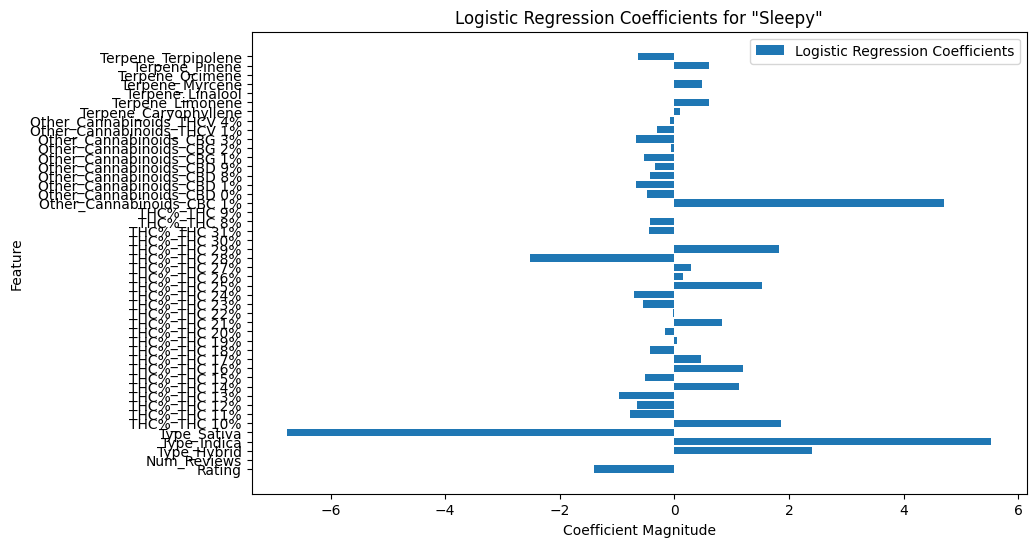

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Sleepy", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Sleepy').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train a Logistic Regression model
logistic_regression_S = LogisticRegression(C=100, random_state=42, max_iter=1000)

# Cross-validation
cv_scores = cross_val_score(logistic_regression_S, X_encoded, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

# Fit the model on the training set
logistic_regression_S.fit(X_train, y_train)

# Make predictions
y_pred_Sleepy = logistic_regression_S.predict(X_test)

# Access the coefficients
coefficients_s = logistic_regression_S.coef_[0]

# Map coefficients to feature names
feature_importance = dict(zip(X_encoded.columns, coefficients_s))

# Print training set score
train_score = logistic_regression_S.score(X_train, y_train)
print("Training Set Score:", train_score)

# Print test set score
test_score = logistic_regression_S.score(X_test, y_test)
print("Test Set Score:", test_score)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_Sleepy))

# Print feature importance
print("Feature Importance:")
for feature, importance in sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {importance}")

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(list(feature_importance.keys()), list(feature_importance.values()))
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients for "Sleepy"')
plt.legend(['Logistic Regression Coefficients'])
plt.show()



#Confusion Matrix and ROC for dertermination if Sleepy

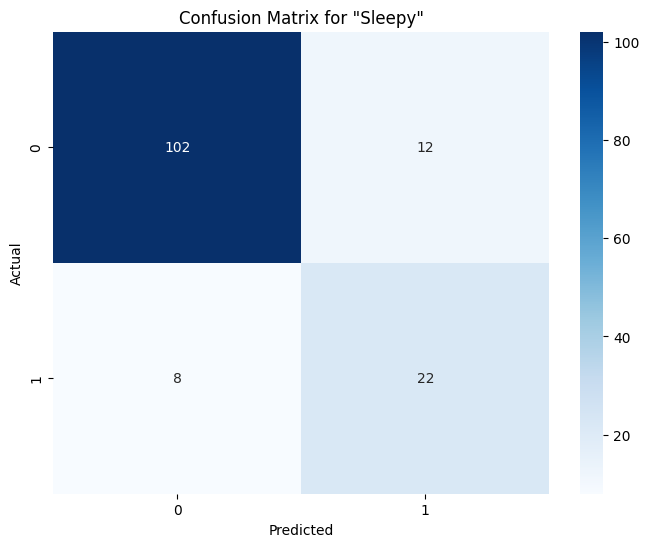

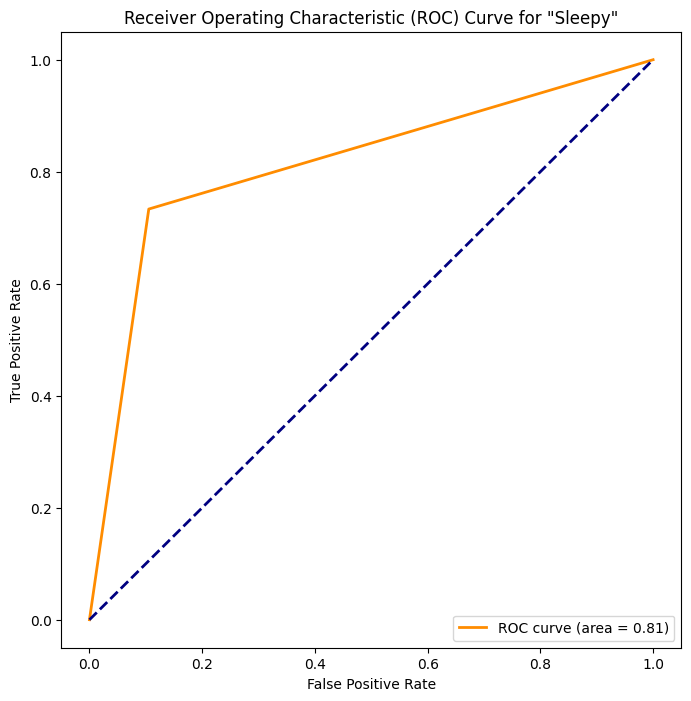

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the true labels y_test and predicted labels y_pred
cm = confusion_matrix(y_test, y_pred_Sleepy)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix for "Sleepy"')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_Sleepy)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for "Sleepy"')
plt.legend(loc='lower right')
plt.show()

#Example 2: Logistic Regression to determine if Main Effect is Energetic

Cross-Validation Scores: [0.65217391 0.93043478 0.86086957 0.90434783 0.86842105]
Mean Cross-Validation Score: 0.8432494279176203
Training Set Score: 0.9395348837209302
Test Set Score: 0.8680555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       124
           1       0.52      0.60      0.56        20

    accuracy                           0.87       144
   macro avg       0.73      0.76      0.74       144
weighted avg       0.88      0.87      0.87       144

Feature Importance:
Other_Cannabinoids_CBD 1%: 6.769140821262203
Type_Sativa: 5.308408620342054
THC%_THC 13%: -5.010869797954409
THC%_THC 11%: -4.736319366942162
THC%_THC 12%: 3.598058994387402
Terpene_Ocimene: 3.3906805405990537
THC%_THC 15%: 2.5763887453427117
Other_Cannabinoids_CBC 1%: -2.4528322719665674
THC%_THC 25%: 2.441848904881602
Terpene_Pinene: -2.3922278974186097
THC%_THC 20%: 2.1122010220658973
Type_Indica: -2.0842357768034776
Ot

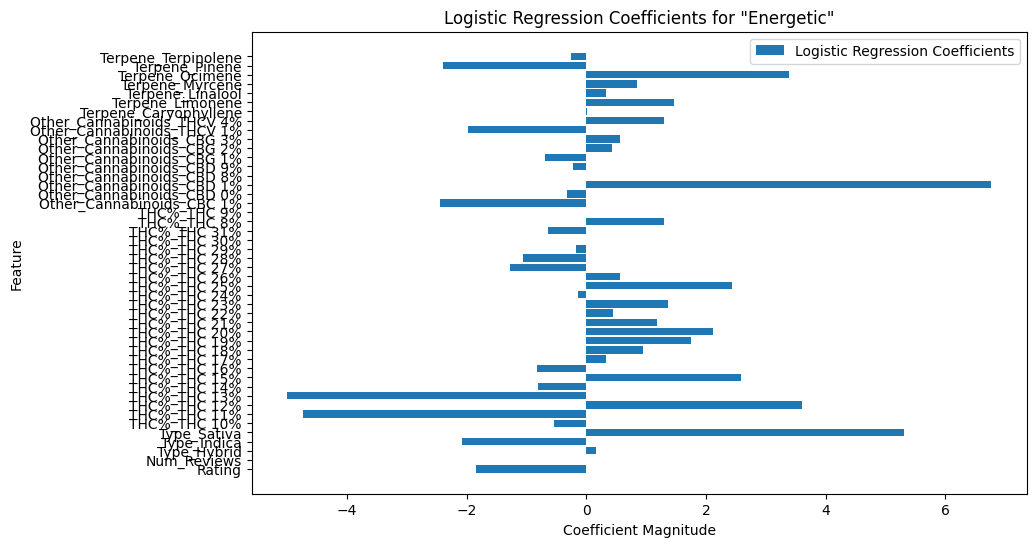

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Energetic", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Energetic').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train a Logistic Regression model
logistic_regression_E = LogisticRegression(C=100, random_state=42, max_iter=1000)

# Cross-validation
cv_scores = cross_val_score(logistic_regression_E, X_encoded, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

# Fit the model on the training set
logistic_regression_E.fit(X_train, y_train)

# Make predictions
y_pred_energetic = logistic_regression_E.predict(X_test)

# Access the coefficients
coefficients_e = logistic_regression_E.coef_[0]

# Map coefficients to feature names
feature_importance = dict(zip(X_encoded.columns, coefficients_e))

# Print training set score
train_score = logistic_regression_E.score(X_train, y_train)
print("Training Set Score:", train_score)

# Print test set score
test_score = logistic_regression_E.score(X_test, y_test)
print("Test Set Score:", test_score)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_energetic))

# Print feature importance
print("Feature Importance:")
for feature, importance in sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {importance}")

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(list(feature_importance.keys()), list(feature_importance.values()))
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients for "Energetic"')
plt.legend(['Logistic Regression Coefficients'])
plt.show()


#Confusion Matrix and ROC for Energetic

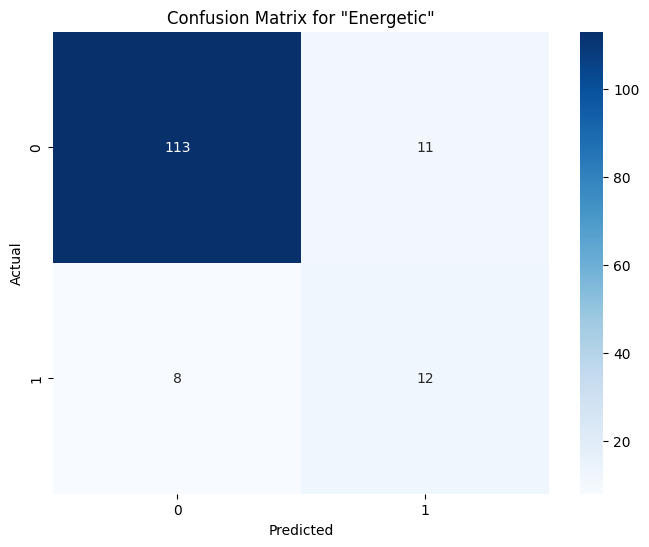

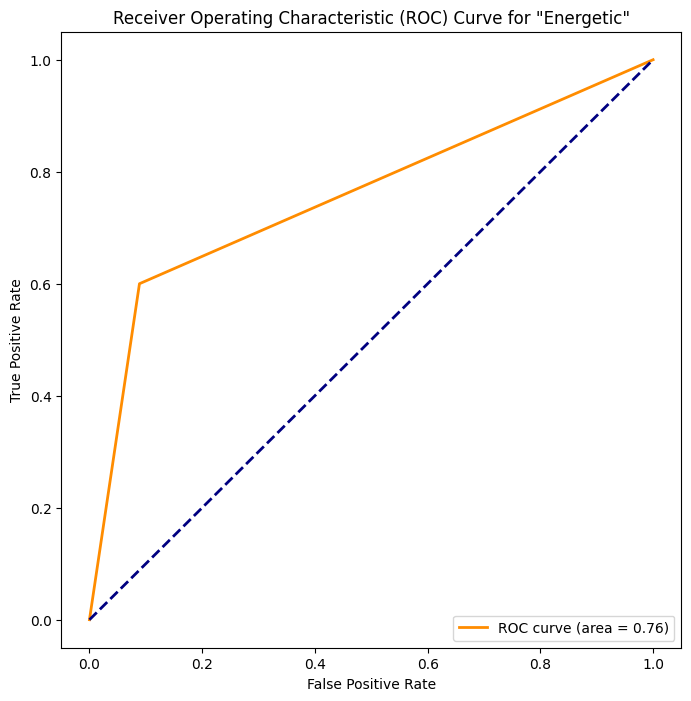

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred_energetic)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix for "Energetic"')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_energetic)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for "Energetic"')
plt.legend(loc='lower right')
plt.show()


Function to Predict if given Terpene will make you Sleepy or Energized 

In [168]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Load the data (assuming the same dataset used for training)
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

#Prediction function 
def predict_effect(terpene):
    # Map terpene to feature values based on feature importance
    feature_values = {
        'Terpene_Caryophyllene': 1 if terpene == 'Caryophyllene' else 0,
        'Terpene_Limonene': 1 if terpene == 'Limonene' else 0,
        'Terpene_Linalool': 1 if terpene == 'Linalool' else 0,
        'Terpene_Myrcene': 1 if terpene == 'Myrcene' else 0,
        'Terpene_Ocimene': 1 if terpene == 'Ocimene' else 0,
        'Terpene_Pinene': 1 if terpene == 'Pinene' else 0,
        'Terpene_Terpinolene': 1 if terpene == 'Terpinolene' else 0
    }

    # Prepare input data for prediction
    input_data = pd.DataFrame([feature_values])

    # Determine the effect based on predictions
    if np.mean(y_pred_energetic) > np.mean(y_pred_Sleepy):
        return "Sleepy"
    elif np.mean(y_pred_energetic) < np.mean(y_pred_Sleepy):
        return "Energetic"
    else:
        return "Other"

# Example usage:
terpene_input = 'Caryophyllene'
effect_prediction = predict_effect(terpene_input)
print(f"The predicted effect for {terpene_input} is: {effect_prediction}")


The predicted effect for Caryophyllene is: Energetic
